# Identifying Spatially Variable Genes (SVGs) with jsPCA

This notebook explores how **jsPCA** performs in identifying spatially variable genes (SVGs) compared to **SPARK-X**.

In [1]:
# ==============================================================
# Import Required Libraries
# ==============================================================

# pandas: for data manipulation and working with tables (DataFrames)
import pandas as pd
# numpy: for numerical operations and arrays
import numpy as np
# matplotlib.pyplot: for creating static plots and figures
import matplotlib.pyplot as plt
# seaborn: for enhanced statistical data visualization (built on matplotlib)
import seaborn as sns
# os: for interacting with the operating system (file paths, directories)
import os

## Intersection Analysis: jsPCA vs SPARK-X

In this section, we compare the top 3000 genes identified by each jsPCA component with the SVGs detected by SPARK-X.
We compute the percentage of SPARK-X genes captured by each component and visualize the results as a heatmap, showing which jsPCA components recover the most spatially variable genes.

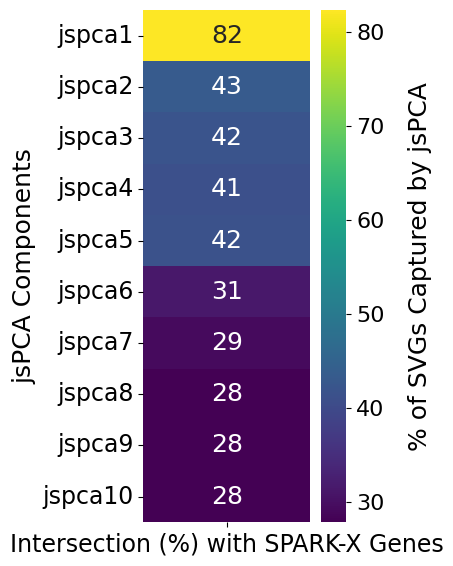

✅ Heatmap saved successfully at: C:\Users\assali.i\Desktop\jsPCA\results\SVGs\intersection_heatmap_151673.png


In [6]:
# ==============================================================
# Configuration
# ==============================================================

# Get base directory (one level up from 'tutorial')
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Define data and results directories
data_dir = os.path.join(base_dir, "data", "SVGs")
results_dir = os.path.join(base_dir, "results", "SVGs")

# Create results directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

# Define file paths (Excel + CSV + output figure)
path_to_excel = os.path.join(data_dir, "sorted_gene_loadings_per_component_151673.xlsx")
path_to_csv = os.path.join(data_dir, "gene_sparkx_151673.csv")
output_image_path = os.path.join(results_dir, "intersection_heatmap_151673.png")

# ==============================================================
# Load SPARK-X results
# ==============================================================

# Read the CSV file containing SPARK-X detected genes
sparkx_df = pd.read_csv(path_to_csv)

# Normalize gene names: remove NaN, trim spaces, convert to uppercase
sparkx_genes = set(sparkx_df['Gene'].dropna().str.upper().str.strip())

# ==============================================================
# Load jsPCA results and compute intersections
# ==============================================================

# Load the Excel file containing jsPCA components
jspca_file = pd.ExcelFile(path_to_excel)

# Dictionary to store intersection percentages per jsPCA component
intersection_percentages = {}

# Loop through all sheets (each representing one jsPCA component)
for sheet_name in jspca_file.sheet_names:
    # Read the sheet
    df = jspca_file.parse(sheet_name)

    # Take the top 3000 genes for this component
    jspca_genes = set(df['Gene'].dropna().str.upper().str.strip().head(3000))

    # Compute intersection with SPARK-X genes
    intersection = jspca_genes.intersection(sparkx_genes)
    percentage = len(intersection) / len(sparkx_genes) * 100

    # Store the percentage for this component
    intersection_percentages[sheet_name] = percentage

# ==============================================================
# Create DataFrame for visualization
# ==============================================================

percentage_df = pd.DataFrame.from_dict(
    intersection_percentages,
    orient='index',
    columns=['Intersection (%) with SPARK-X Genes']
)

# ==============================================================
# Create and save the heatmap
# ==============================================================

plt.figure(figsize=(4.5, 6))

ax = sns.heatmap(
    percentage_df,
    annot=True,
    annot_kws={"size": 18},
    cmap='viridis',
    cbar_kws={'label': '% of SVGs Captured by jsPCA'}
)

ax.set_ylabel("jsPCA Components", fontsize=18)
ax.set_xlabel("")
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
cbar.set_label('% of SVGs Captured by jsPCA', fontsize=18, labelpad=17)

plt.tight_layout()

# Save figure
plt.savefig(output_image_path, dpi=300)
plt.show()

print(f"✅ Heatmap saved successfully at: {output_image_path}")

## Top jsPCA1 Genes: Presence vs Absence in SPARK-X

In this section, we visualize which of the top 3000 jsPCA1 genes are also detected by SPARK-X.
We create a split scatter plot showing genes that are present versus absent in SPARK-X, helping to identify how well the top-ranked jsPCA1 genes overlap with known spatially variable genes.

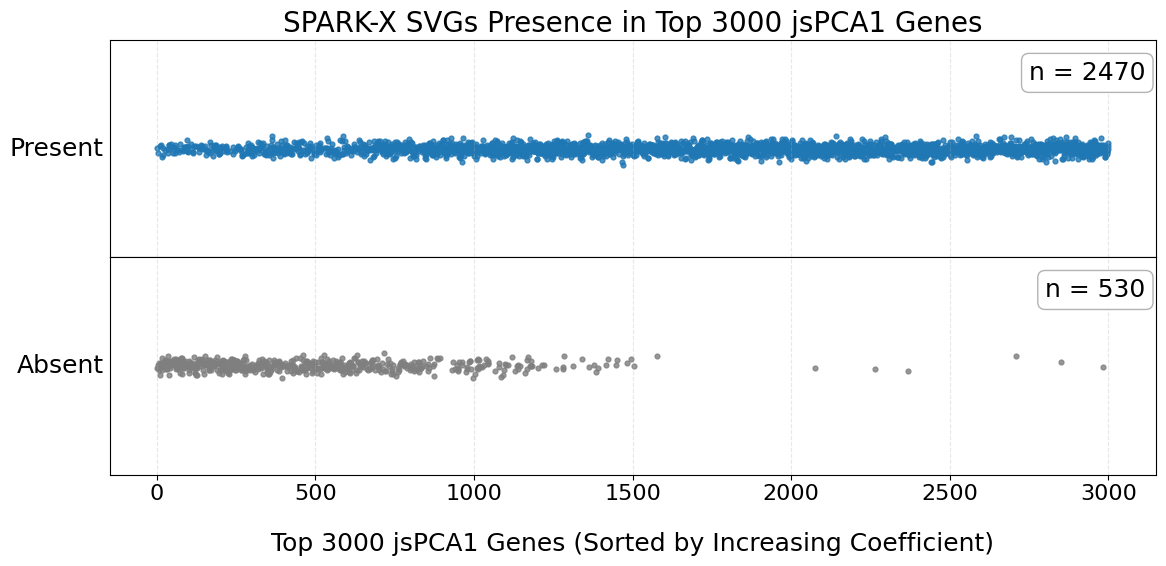

✅ Figure saved successfully at: C:\Users\assali.i\Desktop\jsPCA\results\SVGs\sparkx_split_bands_top3000_jsPCA1_no_space.png


In [5]:
# ==============================================================
# Configuration
# ==============================================================

# Get base directory (one level up from 'tutorial')
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Define data and results directories
data_dir = os.path.join(base_dir, "data", "SVGs")
results_dir = os.path.join(base_dir, "results", "SVGs")

# Create results directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

# Define file paths
jspca_excel = os.path.join(data_dir, "sorted_gene_loadings_per_component_151673.xlsx")
sparkx_csv = os.path.join(data_dir, "gene_sparkx_151673.csv")
output_image_path = os.path.join(results_dir, "sparkx_split_bands_top3000_jsPCA1_no_space.png")

# ==============================================================
# Load and preprocess data
# ==============================================================

# Load SPARK-X genes and normalize names
sparkx_genes = set(pd.read_csv(sparkx_csv)['Gene'].dropna().str.upper().str.strip())

# Load jsPCA results for component 1
df = pd.read_excel(jspca_excel, sheet_name='jspca1')
df['Gene'] = df['Gene'].str.upper().str.strip()

# ==============================================================
# Select and rank top 3000 genes
# ==============================================================

# Step 1: select top 3000 genes by decreasing coefficient
top3000 = df.sort_values('Coefficient', ascending=False).head(3000).copy()

# Step 2: reorder those 3000 by increasing coefficient
top3000 = top3000.sort_values('Coefficient', ascending=True).reset_index(drop=True)

# Mark whether each gene is found in SPARK-X results
top3000['In_SPARKX'] = top3000['Gene'].isin(sparkx_genes)

# ==============================================================
# Prepare indices for plotting
# ==============================================================

# Create rank indices
ranks = np.arange(1, len(top3000) + 1)
present_idx = ranks[top3000['In_SPARKX'].values]
absent_idx  = ranks[~top3000['In_SPARKX'].values]

# Add random jitter for better visualization
rng = np.random.default_rng(42)
jitter_present = rng.normal(0, 0.02, size=len(present_idx))
jitter_absent  = rng.normal(0, 0.02, size=len(absent_idx))

# Count how many are present/absent
n_present = len(present_idx)
n_absent  = len(absent_idx)

# ==============================================================
# Plot: SPARK-X gene presence among top jsPCA1 genes
# ==============================================================

plt.rcParams.update({'font.size': 18})

# Two stacked subplots (present vs absent)
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex=True, figsize=(12, 6),
    gridspec_kw={'hspace': 0}  # no vertical space between subplots
)

# ---------- Top panel: genes present in SPARK-X ----------
ax_top.scatter(present_idx, 0.5 + jitter_present, s=12, alpha=0.8)
ax_top.set_ylim(0, 1)
ax_top.set_yticks([])
ax_top.set_ylabel("Present", rotation=0, ha='right', va='center', fontsize=18)
ax_top.set_title("SPARK-X SVGs Presence in Top 3000 jsPCA1 Genes", fontsize=20)

# Annotate number of present genes
ax_top.text(
    0.99, 0.85, f"n = {n_present}",
    transform=ax_top.transAxes,
    ha='right', va='center',
    fontsize=18,
    bbox=dict(boxstyle="round", fc="white", ec="0.7")
)

# ---------- Bottom panel: genes absent from SPARK-X ----------
ax_bot.scatter(absent_idx, 0.5 + jitter_absent, s=12, alpha=0.8, color='tab:gray')
ax_bot.set_ylim(0, 1)
ax_bot.set_yticks([])
ax_bot.set_ylabel("Absent", rotation=0, ha='right', va='center', fontsize=18)

# Annotate number of absent genes
ax_bot.text(
    0.99, 0.85, f"n = {n_absent}",
    transform=ax_bot.transAxes,
    ha='right', va='center',
    fontsize=18,
    bbox=dict(boxstyle="round", fc="white", ec="0.7")
)

# ---------- Common X label ----------
ax_bot.set_xlabel(
    "Top 3000 jsPCA1 Genes (Sorted by Increasing Coefficient)",
    fontsize=18,
    labelpad=20
)

# Add gridlines and style x-axis
for ax in (ax_top, ax_bot):
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    ax.tick_params(axis='x', labelsize=16)

plt.tight_layout()

# ==============================================================
# Save and display figure
# ==============================================================

plt.savefig(output_image_path, dpi=300)
plt.show()

print(f"✅ Figure saved successfully at: {output_image_path}")

### Distribution of jsPCA1 Coefficients

In this section, we visualize the distribution of jsPCA1 gene coefficients.
We highlight the coefficient of the 3000th ranked gene to indicate the threshold for selecting the top genes.

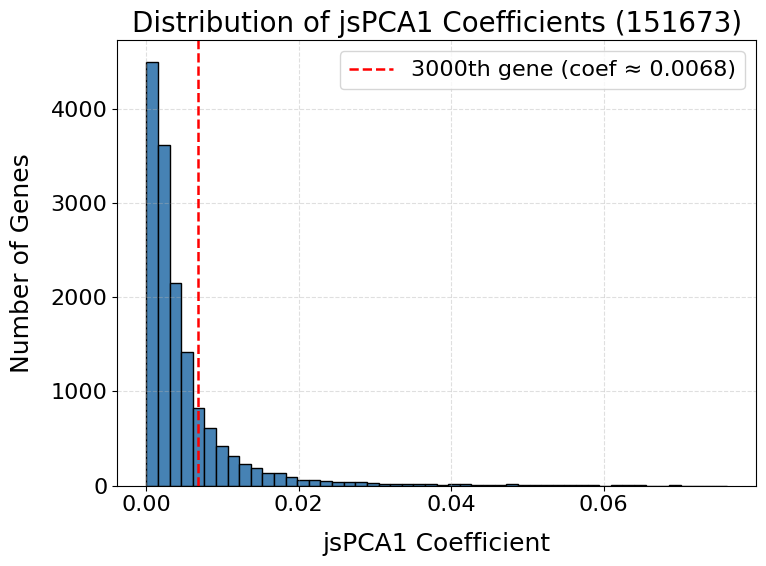

✅ Figure saved successfully at: C:\Users\assali.i\Desktop\jsPCA\results\SVGs\histogram_jspca1_3000th_gene_151673.png


In [7]:
# ==============================================================
# Configuration
# ==============================================================

# Get base directory (one level up from current folder, e.g. tutorial/)
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Define data and output folders (relative to project root)
data_folder = os.path.join(base_dir, "data", "SVGs")
results_folder = os.path.join(base_dir, "results", "SVGs")

# Ensure output folder exists
os.makedirs(results_folder, exist_ok=True)

# Sample name (for DLPFC section or dataset)
sample_name = "151673"

# Define file paths
loadings_file = os.path.join(data_folder, f"sorted_gene_loadings_per_component_{sample_name}.xlsx")
save_path = os.path.join(results_folder, f"histogram_jspca1_3000th_gene_{sample_name}.png")

# ==============================================================
# Load data
# ==============================================================

# Load jsPCA loadings for component 1
df = pd.read_excel(loadings_file, sheet_name="jspca1")

# Ensure that the 'Coefficient' column exists
if "Coefficient" not in df.columns:
    raise KeyError(
        f"Column 'Coefficient' not found in file. Available columns: {df.columns.tolist()}"
    )

# ==============================================================
# Compute coefficient threshold
# ==============================================================

# Extract coefficient values
coeffs = df["Coefficient"].values

# Sort coefficients in descending order
sorted_coeffs = np.sort(coeffs)[::-1]

# Get the coefficient of the 3000th gene (or the last one if < 3000)
coef_3000 = sorted_coeffs[2999] if len(sorted_coeffs) >= 3000 else sorted_coeffs[-1]

# ==============================================================
# Plot histogram
# ==============================================================

plt.figure(figsize=(8, 6))

# Histogram of jsPCA coefficients
plt.hist(coeffs, bins=50, color="steelblue", edgecolor="black")

# Add a vertical line marking the 3000th gene threshold
plt.axvline(
    x=coef_3000, color="red", linestyle="--", linewidth=1.8,
    label=f"3000th gene (coef ≈ {coef_3000:.4f})"
)

# Titles and labels
plt.title(f"Distribution of jsPCA1 Coefficients ({sample_name})", fontsize=20)
plt.xlabel("jsPCA1 Coefficient", fontsize=18, labelpad=12)
plt.ylabel("Number of Genes", fontsize=18, labelpad=12)

# Tick and grid styling
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()

# ==============================================================
# Save and display
# ==============================================================

plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Figure saved successfully at: {save_path}")
